# Blackbird Optimal Control

This notebook goes into using neural networks for optimal control. The Blackbird set has multiple flight paths but control scheme for the quadcopter is a nonlinear inverse dynamic controller. This notebook is exploring various neural networks for trying to learn the optimal controller.

## Load in data

Setting up libraries that will be needed as well as a function to download a flight test from the Blackbird Dataset

In [1]:
import copy
import importlib
import os
import sys
import time
# sys.path.append(os.path.abspath('../functions'))
sys.path.append(os.path.abspath('../models'))

from thesis.data import blackbird_dataset as rbd
from thesis.modules import dsp, quaternions

import math
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numba
import numpy as np
import pandas as pd

from sklearn import model_selection
import tensorflow as tf

# Please work
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Initial read in flight test
def cleaned_blackbird_test(maneuver, yaw_direction, max_speed):
    test_df = rbd.read_blackbird_test(maneuver, yaw_direction, max_speed)
    rbd.imu_installation_correction(test_df)
    test_df = rbd.inertial_position_derivatives_estimation(test_df)
    test_df = rbd.gyroscope_derivatives_estimation(test_df)
    test_df = rbd.consistent_quaternions(test_df)
    test_df = rbd.inertial_quaternion_derivatives_estimation(test_df)
    test_df = rbd.body_quaternion_angular_derivative_estimate(test_df)
    test_df = rbd.motor_scaling(test_df)
    test_df = rbd.motor_rates(test_df)
    test_df = rbd.quaternion_body_acceleration(test_df)
    test_df = rbd.detrend_pwm(test_df)
    test_df = rbd.scale_and_filter_pwms(test_df)
    test_df = rbd.on_ground(test_df)  # Must be last function
    return test_df

test_df = cleaned_blackbird_test('figure8', 'Constant', 0.5)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781699 entries, 1526617312016142000 to 1526617526748159000
Data columns (total 95 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PWM1                            39823 non-null   float64
 1   PWM1_f                          39823 non-null   float64
 2   PWM2                            39823 non-null   float64
 3   PWM2_f                          39823 non-null   float64
 4   PWM3                            39823 non-null   float64
 5   PWM3_f                          39823 non-null   float64
 6   PWM4                            39823 non-null   float64
 7   PWM4_f                          39823 non-null   float64
 8   angular_velocity_covariance     21298 non-null   object 
 9   ax_B_[m/s2]                     77287 non-null   float64
 10  ax_I_[m/s2]                     77287 non-null   float64
 11  ax_[m/s2]                       21298 non-null 

In [3]:
pwms_df = test_df[['PWM1_f', 'PWM2_f', 'PWM3_f', 'PWM4_f']].dropna()
tvec = (pwms_df.index - test_df.index[0]) * (10**-9)
tvec = tvec.astype('float').values
pwms = pwms_df.values

fig = plt.figure()

ax = fig.add_axes([0.15, 0.1, 0.8, 0.8])
ax.plot(tvec, pwms[:, 0], label='PWM1')
ax.plot(tvec, pwms[:, 1], label='PWM2')
ax.plot(tvec, pwms[:, 2], label='PWM3')
ax.plot(tvec, pwms[:, 3], label='PWM4')

ax.set_xlabel("Time ($t$) [sec]")
ax.set_ylabel("Pulse Width Modulation [$\mu$sec]")
ax.legend()
ax.grid()
plt.show()

<IPython.core.display.Javascript object>

## Creating Training and Test Sets

The idea is that given the data in a past time window and given the future commanded position and orientation in future, then the a sequence of nominal command values can be given. The nominal command values can form the bases for a nonlinear control around some inner controller that closes the loop.

In [4]:
# Get a function to generate data based on windowing
def generate_test_data(test_df, past_delta_t, future_delta_t, downsample_dict=None):
    """
    Args:
        test_df (pd.DataFrame): Flight test data frame to look at
        past_delta_t (float): time in seconds to gather past data in [current_time - past_delta_t, current_time] window.
        future_delta_t (float): time in seconds to gather past data in [current_time, current_time + future_delta_t] window.
        dowsample_dict (dict): dictionary whose keys are the variables used in training and tests with positive integers 
                                for relative downsample rate. The keys are stride_var with var being pos, att, pos_ref, 
                                att_ref, motor_speeds, accel, gyro, or pwms.
    """
    
    # Dictionary default
    if downsample_dict is None:
        downsample_dict = {
            'stride_pos': 1,
            'stride_att': 1,
            'stride_pos_ref': 1,
            'stride_att_ref': 1,
            'stride_motor_speeds': 1,
            'stride_accel': 1,
            'stride_gyro': 1,
            'stride_pwms': 1
        }
    
    # Get inputs to optimal control sequence
    # pos., att., ref pos., ref att. ,motor speeds., acc., gyro
    pos = test_df[['px_[m]', 'py_[m]', 'pz_[m]']].dropna()
    pos_ref = test_df[['pxr_[m]', 'pyr_[m]', 'pzr_[m]']].dropna()
    att = test_df[['qw', 'qx', 'qy', 'qz']].dropna()
    att_ref = test_df[['qwr', 'qxr', 'qyr', 'qzr']].dropna()
    motor_speeds = test_df[['rpm1', 'rpm2', 'rpm3', 'rpm4']].dropna()
    accel = test_df[['ax_[m/s2]', 'ay_[m/s2]', 'az_[m/s2]']].dropna()
    gyro = test_df[['omegax_[dps]', 'omegay_[dps]', 'omegaz_[dps]']].dropna()

    # Get control
    pwms = test_df[test_df['is_flying']]
    pwms = pwms[['PWM1_f', 'PWM2_f', 'PWM3_f', 'PWM4_f']].dropna()
    
    # Get time vectors for history
    def get_tvec(state_df):
        tvec = (state_df.index - test_df.index[0]) * (10**-9)
        tvec = tvec.astype('float')
        return tvec.values
    
    # Time Vector
    t_pos = get_tvec(pos)
    t_att = get_tvec(att)
    t_pref = get_tvec(pos_ref)
    t_aref = get_tvec(att_ref)
    t_motors = get_tvec(motor_speeds)
    t_acc = get_tvec(accel)
    t_gyro = get_tvec(gyro)
    t_pwms = get_tvec(pwms)
    
    # Dataframe to numpy
    def df_to_numpy(state_df):
        return state_df.values
    
    pos = df_to_numpy(pos)
    att = df_to_numpy(att)
    pos_ref = df_to_numpy(pos_ref)
    att_ref = df_to_numpy(att_ref)
    motor_speeds = df_to_numpy(motor_speeds)
    accel = df_to_numpy(accel)
    gyro = df_to_numpy(gyro)
    pwms = df_to_numpy(pwms)

    # Scaling all numpy data to [0,1] range or [-1,1] range based either on flight test bounds or hardware bounds
    pos = pos/5.  # All flight tests are within 10m cube with Z being [-5,0]
    pos_ref = pos_ref/5.
    # attitude is already a unit scaling
    """
    From initial BB notebook, 0.125 change in frac. throttle gives ~2500 rpm change. Snail gives 2400 rpm/V so if
    assuming linear scaling for rpm a max of 20,000 rpm and a voltage of 8.33 V. From reference it looks like 3S LiPo 
    battery with nominal voltage of 11.1 V. Seems to be short a cell for traditional race/freestyle quads.
    
    Snail:
        https://www.dji.com/snail/info#specs
        https://dl.djicdn.com/downloads/snail/20170315/SNAIL+2305+Racing+Motor_multi.pdf
    Other:
        https://www.getfpv.com/learn/new-to-fpv/all-about-multirotor-fpv-drone-battery/#:~:text=The%20lithium%20battery%20packs%20used,4.35V%20at%20full%20charge.
    """
    motor_speeds = motor_speeds/20000.
    # https://www.xsens.com/hubfs/Downloads/Manuals/MTi-1-series-datasheet.pdf?hsCtaTracking=6999e406-3b81-44e2-8e2d-5ecf00e23d87%7Ced790e48-f312-4c41-ad3b-50931a26a420
    accel = accel/(2*9.81)  # Full scale is +/- 16 g's but I think 2 will be fine
    gyro = gyro/1000.  # Full scale is +/- 20000 deg/s
    pwms = (pwms - 1000.)/1000.
    
    
    
    # Determine deltas for windowing
    dt_pos = np.median(np.diff(t_pos))
    dt_att = np.median(np.diff(t_att))
    dt_pref = np.median(np.diff(t_pref))
    dt_aref = np.median(np.diff(t_aref))
    dt_motors = np.median(np.diff(t_motors))
    dt_acc = np.median(np.diff(t_acc))
    dt_gyro = np.median(np.diff(t_gyro))
    dt_pwms = np.median(np.diff(t_pwms)) # The medium will take care of any gaps
    
    # Find number of state values
    n_pos = int(np.floor(past_delta_t/dt_pos))
    n_att = int(np.floor(past_delta_t/dt_att))
    n_pref = int(np.floor(future_delta_t/dt_pref))
    n_aref = int(np.floor(future_delta_t/dt_aref))
    n_motors = int(np.floor(past_delta_t/dt_motors))
    n_acc = int(np.floor(past_delta_t/dt_acc))
    n_gyro = int(np.floor(past_delta_t/dt_gyro))
    n_pwms = int(np.floor(future_delta_t/dt_pwms))
    
    # Record this in a dictionary
    info = {
        'vicon position': (n_pos, dt_pos),
        'vicon attitude': (n_att, dt_att),
        'reference position': (n_pref, dt_pref),
        'reference attitude': (n_aref, dt_aref),
        'motor speeds': (n_motors, dt_motors),
        'accelerometer': (n_acc, dt_acc),
        'gyroscope': (n_gyro, dt_gyro),
        'PWM': (n_pwms, dt_pwms)
    }
    
    # Preallocate input and output vectors
    N = t_pwms.shape[0] - n_pwms + 1 # Edit N to mai
    X = np.zeros((
        N,
        int(np.ceil(n_pos/downsample_dict['stride_pos']))*pos.shape[1] + 
        int(np.ceil(n_att/downsample_dict['stride_att']))*att.shape[1] + 
        int(np.ceil(n_pref/downsample_dict['stride_pos_ref']))*pos_ref.shape[1] + 
        int(np.ceil(n_aref/downsample_dict['stride_att_ref']))*att_ref.shape[1] + 
        int(np.ceil(n_motors/downsample_dict['stride_motor_speeds']))*motor_speeds.shape[1] +
        int(np.ceil(n_acc/downsample_dict['stride_accel']))*accel.shape[1] + 
        int(np.ceil(n_gyro/downsample_dict['stride_gyro']))*gyro.shape[1]
    ))
    Y = np.zeros((N, int(np.ceil(n_pwms/downsample_dict['stride_pwms']))*pwms.shape[1]))
    tvec_y = np.zeros((N, int(np.ceil(n_pwms/downsample_dict['stride_pwms']))))
    
    """
    # Loop through (~ 180 secs)
    for i in range(N):
        # allocate output values
        Y[i,:] = pwms[i:i+n_pwms, :].flatten('F')
        
        # Sampling time
        t_sample = t_pwms[i]
        
        # Accumulate input states
        pos_line = pos[t_pos <= t_sample, :][-n_pos:, :].flatten('F')
        att_line = att[t_att <= t_sample, :][-n_att:, :].flatten('F')
        pref_line = pos_ref[t_sample <= t_pref, :][:n_pref, :].flatten('F')
        aref_line = att_ref[t_sample <= t_aref, :][:n_aref, :].flatten('F')
        motors_line = motor_speeds[t_motors <= t_sample, :][-n_motors:, :].flatten('F')
        acc_line = accel[t_acc <= t_sample, :][-n_acc:, :].flatten('F')
        gyro_line = gyro[t_gyro <= t_sample, :][-n_gyro:, :].flatten('F')
        
        # Put input states into input row already flattened
        X[i, :] = np.concatenate((
            pos_line, pref_line, att_line, aref_line, motors_line, acc_line, gyro_line
        ))
    
        # Update expected time
        tvec_y[i, :] = t_sample + dt_pwms*np.arange(0, n_pwms)
    """
    
    # ~100 secs
    @numba.jit(nopython=True)
    def fast_generator(
        X, Y, tvec_y,
        pos, att, pos_ref, att_ref, motor_speeds, accel, gyro, pwms,
        n_pos, n_att, n_pref, n_aref, n_motors, n_acc, n_gyro, n_pwms,
        stride_pos, stride_att, stride_pos_ref, stride_att_ref, stride_motor_speeds, stride_accel, stride_gyro, stride_pwms
    ):
        pwm_length = int(Y.shape[1]/4)
        for i in numba.prange(N):
            # allocate output values
            for j in range(pwms.shape[1]):
                Y[i,j*pwm_length:(j+1)*pwm_length] = pwms[i:i+n_pwms:stride_pwms, j]

            # Sampling time
            t_sample = t_pwms[i]

            def numba_2d_fortran_flatten(X):
                Xflattened = np.zeros((X.shape[0]*X.shape[1],))
                ni = X.shape[0]
                for j in range(X.shape[1]):
                    Xflattened[j*ni:(j+1)*ni] = X[:,j]
                return Xflattened
            
            # Accumulate input states
            # Position
            pos_line = numba_2d_fortran_flatten(pos[t_pos <= t_sample, :][-n_pos::stride_pos, :])
            att_line = numba_2d_fortran_flatten(att[t_att <= t_sample, :][-n_att::stride_att, :])
            pref_line = numba_2d_fortran_flatten(pos_ref[t_sample <= t_pref, :][:n_pref:stride_pos_ref, :])
            aref_line = numba_2d_fortran_flatten(att_ref[t_sample <= t_aref, :][:n_aref:stride_att_ref, :])
            motors_line = numba_2d_fortran_flatten(motor_speeds[t_motors <= t_sample, :][-n_motors::stride_motor_speeds, :])
            acc_line = numba_2d_fortran_flatten(accel[t_acc <= t_sample, :][-n_acc::stride_accel, :])
            gyro_line = numba_2d_fortran_flatten(gyro[t_gyro <= t_sample, :][-n_gyro::stride_gyro, :])

            # Put input states into input row already flattened
            if X.shape[1] == (pos_line.shape[0] + pref_line.shape[0] +
                              att_line.shape[0] + aref_line.shape[0] +
                              motors_line.shape[0] + 
                              acc_line.shape[0] + gyro_line.shape[0]):
                X[i, :] = np.concatenate((
                    pos_line, pref_line, att_line, aref_line, motors_line, acc_line, gyro_line
                ))
            else:
                X[i, :] = np.nan

            # Update expected time
            tvec_y[i, :] = t_sample + dt_pwms*(np.arange(0, n_pwms)[::stride_pwms])
    
    fast_generator(
        X, Y, tvec_y, 
        pos, att, pos_ref, att_ref, motor_speeds, accel, gyro, pwms,
        n_pos, n_att, n_pref, n_aref, n_motors, n_acc, n_gyro, n_pwms,
        **downsample_dict
    )
    
    # Get rid of invalid segments
    ind_valid = np.all(np.isfinite(X), axis=1)
    X = X[ind_valid]
    Y = Y[ind_valid]
    tvec_y = tvec_y[ind_valid]
    
    return (X, Y, tvec_y, info)

# It took 0.687284 seconds to do everything up to all the sorting

if True:
    t1 = time.time()
    _, _, _, output = generate_test_data(test_df, 0.05, 0.05)
    t2 = time.time()
    print("Elapsed time is %f [s]" % (t2-t1))
    print("Output Summary")
    for k in output.keys():
        n, dt = output[k]
        print("\t%s: %i [samples]\t%f [Hz]" %(k, n, 1./dt))

Elapsed time is 79.682909 [s]
Output Summary
	vicon position: 17 [samples]	359.971202 [Hz]
	vicon attitude: 17 [samples]	359.971202 [Hz]
	reference position: 9 [samples]	188.465888 [Hz]
	reference attitude: 9 [samples]	188.465888 [Hz]
	motor speeds: 9 [samples]	187.899286 [Hz]
	accelerometer: 5 [samples]	100.000000 [Hz]
	gyroscope: 5 [samples]	100.000000 [Hz]
	PWM: 9 [samples]	187.934599 [Hz]


## Initial Training 

Training a simple network to get a baseline model before attempting to try and parameter tuning with regards to window lengths or network size.

In [5]:
downsample_dict = {
            'stride_pos': 36,
            'stride_att': 36,
            'stride_pos_ref': 19,
            'stride_att_ref': 19,
            'stride_motor_speeds': 19,
            'stride_accel': 10,
            'stride_gyro': 10,
            'stride_pwms': 19
        }
X, Y, tvec_y, output = generate_test_data(test_df, 1., 1., downsample_dict)
print("Output Summary")
for ko, kd in zip(output.keys(), downsample_dict.keys()):
    n, dt = output[ko]
    d = downsample_dict[kd]
    print("\t%s: %i [samples]\t%f [Hz]" %(ko, int(np.ceil(n/d)), 1./(dt*d)))

Output Summary
	vicon position: 10 [samples]	9.999200 [Hz]
	vicon attitude: 10 [samples]	9.999200 [Hz]
	reference position: 10 [samples]	9.919257 [Hz]
	reference attitude: 10 [samples]	9.919257 [Hz]
	motor speeds: 10 [samples]	9.889436 [Hz]
	accelerometer: 10 [samples]	10.000000 [Hz]
	gyroscope: 10 [samples]	10.000000 [Hz]
	PWM: 10 [samples]	9.891295 [Hz]


In [6]:
dX = X.shape[1]
dY = Y.shape[1]

# Build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=X.shape[1:]))
for n in range(2,10):
    model.add(tf.keras.layers.Dense(max(dY, int(dX/n)), activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(Y.shape[1], activation=tf.nn.relu))

@tf.function
def sse_and_max(y_actual, y_pred):  # degree is polynomial degree
    sse = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_actual),  # squared error part
                       axis=1)
    max_error = tf.keras.backend.max(
        tf.keras.backend.abs(y_pred - y_actual),
        axis=1
    )
    
    return tf.keras.backend.sum(sse + max_error)

@tf.function
def sse_and_smoothness(
    y_actual, y_pred,
    degree=tf.constant(5), # degree is polynomial degree
    alpha=tf.constant(0.1) #linear weighting between sse and smoothness
):  
    sse_points = tf.keras.backend.sum(
        tf.keras.backend.square(y_pred - y_actual),  # squared error part
    )    # axis=1  # This may be unnecessary
    #)

    # Compute X for LSE where input is simply and integer list
    base, power = tf.meshgrid(
        tf.keras.backend.cast_to_floatx(tf.range(tf.shape(Y)[1]/tf.constant(4))),
        tf.keras.backend.cast_to_floatx(tf.range(degree + tf.constant(1))),
        indexing='ij'
    )
    X = tf.math.pow(base, power)
    XtXinvXt = tf.linalg.matmul(tf.linalg.inv(tf.linalg.matmul(X, X, transpose_a=True)), X, transpose_b=True)
    
    # With 4 PWMs being concatenated down, need to know length of individual PWM signal
    pwm_offset = tf.cast(tf.shape(y_actual)[1]/tf.constant(4), tf.int32)

    # Loop over given data
    """
    sse_continuity = tf.constant(0.)
    for i in tf.range(tf.shape(y_actual)[0]):
        # Loop over PWM signals
        for j in tf.range(4):
            # Column y vector
            y, _ = tf.meshgrid(
                y_pred[i, j*pwm_offset:(j+tf.constant(1))*pwm_offset],
                tf.keras.backend.cast_to_floatx(tf.range(tf.constant(1))),
                indexing='ij'
            )
            # LS estimator
            theta = tf.linalg.matmul(XtXinvXt, y)
            error_continuity = y - tf.linalg.matmul(X, theta)
            sse_continuity = sse_continuity + tf.keras.backend.sum(tf.keras.backend.square(error_continuity))
    """

    def continuity_sse(pwm_channel):
        """Calculate SSE from polynomial"""
        y, _ = tf.meshgrid(
            pwm_channel,
            tf.keras.backend.cast_to_floatx(tf.range(tf.constant(1))),
            indexing='ij'
        )
        # LS estimator
        theta = tf.linalg.matmul(XtXinvXt, y)
        error_continuity = y - tf.linalg.matmul(X, theta)
        return tf.keras.backend.sum(tf.keras.backend.square(error_continuity))
    

    def pwm_iterator(predicted_values):
        pwm_channel = tf.reshape(predicted_values, [tf.constant(4), pwm_offset])
        pwm_sse = tf.vectorized_map(fn=continuity_sse, elems=pwm_channel)
        return tf.keras.backend.sum(pwm_sse)
    
    sse_continuity = tf.vectorized_map(
        fn=pwm_iterator,
        elems=y_pred
    )
    
    return (tf.constant(1.) - alpha)*sse_points + alpha*tf.keras.backend.sum(sse_continuity)


    
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.mse,
    # loss=sse_and_smoothness,
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               28920     
_________________________________________________________________
dense_1 (Dense)              (None, 80)                9680      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 48)                2928      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1960      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1

In [7]:
# Training
tf.random.set_seed(42)  # Meaning of life

hist = None

weights_file = "../models/optcon_model_weights.keras"

for i in range(1):
    loss_fn = tf.keras.losses.mse if i == 0 else sse_and_smoothness
    train_epochs = 100 if i == 0 else 1000
    
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        # loss=sse_and_smoothness,
        metrics=['mse'],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
    )

    if True:
        model.load_weights(weights_file)
    if i != 0:
        model.load_weights(weights_file)
    
    temp_hist = model.fit(
        x=X, y=Y,
        batch_size=1000,
        epochs=train_epochs,
        verbose=1,
        validation_split=0.3,  # 70-30 train validation split
        shuffle=True,
        validation_freq=1,
    )
    
    model.save_weights(weights_file)
    
    if hist is None:
        hist = temp_hist
    else:
        for k in hist.history.keys():
            hist.history[k] = hist.history[k] + temp_hist.history[k]
    

Train on 26662 samples, validate on 11427 samples
Epoch 1/100
26662/26662 [==============================] - 2s 59us/sample - loss: 5.1409e-06 - mse: 5.1409e-06 - val_loss: 2.6295e-04 - val_mse: 2.6295e-04
Epoch 2/100
26662/26662 [==============================] - 0s 9us/sample - loss: 4.6805e-06 - mse: 4.6805e-06 - val_loss: 2.3589e-04 - val_mse: 2.3589e-04
Epoch 3/100
26662/26662 [==============================] - 0s 8us/sample - loss: 5.1933e-06 - mse: 5.1933e-06 - val_loss: 2.4987e-04 - val_mse: 2.4987e-04
Epoch 4/100
26662/26662 [==============================] - 0s 8us/sample - loss: 6.4074e-06 - mse: 6.4074e-06 - val_loss: 2.3911e-04 - val_mse: 2.3911e-04
Epoch 5/100
26662/26662 [==============================] - 0s 8us/sample - loss: 5.3488e-06 - mse: 5.3488e-06 - val_loss: 3.0993e-04 - val_mse: 3.0993e-04
Epoch 6/100
26662/26662 [==============================] - 0s 9us/sample - loss: 5.0839e-06 - mse: 5.0839e-06 - val_loss: 3.0555e-04 - val_mse: 3.0555e-04
Epoch 7/100
26662/2

In [8]:
# plot predicted versus actual outputs
fig = plt.figure()
fig.set_size_inches(8,4)

ax = fig.add_axes([0.1, 0.15, 0.75, 0.8])

ypred = 1000.*model.predict(X) + 1000.
ypred = ypred.reshape((ypred.shape[0], int(ypred.shape[1]/4.), 4), order='F')

n = 500 # 1000

ax.plot(tvec, pwms[:,0], label='PWM1 Filtered')
ax.plot(tvec, pwms[:,1], label='PWM2 Filtered')
ax.plot(tvec, pwms[:,2], label='PWM3 Filtered')
ax.plot(tvec, pwms[:,3], label='PWM4 Filtered')

for i in range(int(ypred.shape[0]/n)):
    for j in range(4):
        ax.plot(
            tvec_y[n*i, :],
            ypred[n*i, :, j],
            color=('C%i' % j),
            marker='x',
            alpha=0.6,
            label=(('' if i == 0  else '_') + ('PWM%i' % (j+1)) + ' Predicted')
        )

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='xx-small', handlelength=1)

ax.set_xlabel('Time ($t$), [sec]')
ax.set_ylabel('Pulse Width Modulation [$\mu$sec]')
plt.show()

<IPython.core.display.Javascript object>

In [9]:
fig, ax_t = plt.subplots(1, 1)

lvec = np.array(hist.history['loss'])
vlvec = np.array(hist.history['val_loss'])
epoch_vec = np.array(list(range(lvec.shape[0])))
    
ax_t.plot(epoch_vec, lvec, label='Training loss')
ax_t.plot(epoch_vec, vlvec, linestyle=':', label='Validation loss')

ax_t.set_xlim(left=0)
ax_t.set_ylim(bottom=0)

fig.suptitle('Training Losses')
ax_t.legend(fontsize='xx-small', handlelength=1)
ax_t.set_xlabel('Epochs')
ax_t.set_ylabel('Losses (MSE)')
plt.show()

<IPython.core.display.Javascript object>

## Aggregate Training

The initial model is trained for 800 epochs using the mean squared error model. This give predicted outputs that are in the correct range but not necessarily smooth control outputs. This next section will use the loss function with the smoothness loss function with different polynomial degrees.

In [10]:
# File of previous training
weights_file = "../models/optcon_model_weights_8e3_epochs_MSE.keras"

# History for training
pred_hist = []
training_hist = []

for i in range(2, 6):
    def loss_fn(y_actual, y_pred):
        return sse_and_smoothness(y_actual, y_pred, tf.constant(i))
    
    train_epochs = 100 # 4000
    
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        metrics=['mse'],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
    )

    # Get the previous training
    if True:
        model.load_weights(weights_file)
    
    # Train with smoothness
    hist = model.fit(
        x=X, y=Y,
        batch_size=1000,
        epochs=train_epochs,
        verbose=1,
        validation_split=0.1,  # Adjust validation split?
        shuffle=True,
        validation_freq=1,
    )
    
    ypred = 1000.*model.predict(X) + 1000.
    ypred = ypred.reshape((ypred.shape[0], int(ypred.shape[1]/4.), 4), order='F')
    
    # Append the results
    training_hist.append(hist)
    pred_hist.append(ypred)

Train on 34280 samples, validate on 3809 samples
Epoch 1/100


C:\Users\Patrick\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


34280/34280 [==============================] - 2s 60us/sample - loss: 0.3675 - mse: 9.9113e-06 - val_loss: 6.9146 - val_mse: 2.2164e-04
Epoch 2/100
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1865 - mse: 4.8796e-06 - val_loss: 5.8630 - val_mse: 1.8559e-04
Epoch 3/100
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1633 - mse: 4.2519e-06 - val_loss: 10.1502 - val_mse: 3.3159e-04
Epoch 4/100
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1698 - mse: 4.4369e-06 - val_loss: 7.9855 - val_mse: 2.5819e-04
Epoch 5/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1320 - mse: 3.4693e-06 - val_loss: 8.4211 - val_mse: 2.7323e-04
Epoch 6/100
34280/34280 [==============================] - 0s 9us/sample - loss: 0.2735 - mse: 7.3608e-06 - val_loss: 4.3685 - val_mse: 1.3577e-04
Epoch 7/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1820 - mse: 4.8353e-06 - val_loss: 2.5645 - v

34280/34280 [==============================] - 0s 9us/sample - loss: 0.1947 - mse: 5.2548e-06 - val_loss: 2.5114 - val_mse: 7.1870e-05
Epoch 12/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0790 - mse: 2.0191e-06 - val_loss: 2.3942 - val_mse: 6.8359e-05
Epoch 13/100
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0669 - mse: 1.6680e-06 - val_loss: 2.4864 - val_mse: 7.1064e-05
Epoch 14/100
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0604 - mse: 1.5027e-06 - val_loss: 2.3778 - val_mse: 6.8035e-05
Epoch 15/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0659 - mse: 1.6274e-06 - val_loss: 2.9646 - val_mse: 8.7779e-05
Epoch 16/100
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0584 - mse: 1.4191e-06 - val_loss: 2.4591 - val_mse: 7.0335e-05
Epoch 17/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0745 - mse: 1.8723e-06 - val_loss: 2.3497

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0986 - mse: 2.6124e-06 - val_loss: 6.3268 - val_mse: 2.0098e-04
Epoch 22/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0648 - mse: 1.6624e-06 - val_loss: 8.3839 - val_mse: 2.7234e-04
Epoch 23/100
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0539 - mse: 1.3533e-06 - val_loss: 6.2037 - val_mse: 1.9632e-04
Epoch 24/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1135 - mse: 3.0248e-06 - val_loss: 7.7050 - val_mse: 2.4763e-04
Epoch 25/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0735 - mse: 1.9152e-06 - val_loss: 7.9399 - val_mse: 2.5513e-04
Epoch 26/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0554 - mse: 1.3958e-06 - val_loss: 7.6646 - val_mse: 2.4639e-04
Epoch 27/100
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0502 - mse: 1.3149e-06 - val_loss: 9.5998

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9455 - mse: 2.0557e-06 - val_loss: 10.0973 - val_mse: 1.9900e-04
Epoch 32/100
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9372 - mse: 1.8115e-06 - val_loss: 9.7719 - val_mse: 1.8721e-04
Epoch 33/100
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9446 - mse: 2.0435e-06 - val_loss: 10.6253 - val_mse: 2.1653e-04
Epoch 34/100
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9422 - mse: 1.9499e-06 - val_loss: 10.4565 - val_mse: 2.1067e-04
Epoch 35/100
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9431 - mse: 1.9732e-06 - val_loss: 9.2325 - val_mse: 1.6887e-04
Epoch 36/100
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9537 - mse: 2.2753e-06 - val_loss: 11.3525 - val_mse: 2.4070e-04
Epoch 37/100
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9848 - mse: 3.1486e-06 - val_loss: 7.

In [11]:
# Plotting the control outputs
fig, ax = plt.subplots(2,2)

# Targets
ax[0, 0].plot(tvec, pwms[:,0], label='PWM1 Filtered', color='C0')
ax[0, 1].plot(tvec, pwms[:,1], label='PWM2 Filtered', color='C1')
ax[1, 1].plot(tvec, pwms[:,2], label='PWM3 Filtered', color='C2')
ax[1, 0].plot(tvec, pwms[:,3], label='PWM4 Filtered', color='C3')

# Trained outputs
n = 500 # 1000

for d, ypred in enumerate(pred_hist):
    pred_color = 'C%i' % d
    for i in range(int(ypred.shape[0]/n)):
        for j in range(4):
            # Get right plot
            if j == 0:
                pax = ax[0, 0]
            elif j == 1:
                pax = ax[0, 1]
            elif j == 2:
                pax = ax[1, 1]
            else:
                pax = ax[1, 0]

            pax.plot(
                tvec_y[n*i, :],
                ypred[n*i, :, j],
                color=pred_color,
                #marker='x',
                alpha=0.6,
                label=(
                    ('' if i == 0 and j == 0 else '_') + 
                    ('Degree %i' % (d+2))
                )
            )
ax[0,0].legend()
plt.show()

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots(1, 1)

for d, hist in enumerate(training_hist):
    c = 'C%i' % d
    # Vectors for plotting
    lvec = np.array(hist.history['loss'])
    vlvec = np.array(hist.history['val_loss'])
    epoch_vec = np.array(list(range(lvec.shape[0])))
    
    ax.plot(epoch_vec, lvec, color=c, label=('Degree %i training loss' % (d + 2)))
    ax.plot(epoch_vec, vlvec, color=c, linestyle=':', label=('Degree %i validation loss' % (d + 2)))

fig.suptitle('Training Losses')
ax.legend(fontsize='xx-small', handlelength=1)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.show()

<IPython.core.display.Javascript object>

## Bezier Loss Function

Trying out the Bezier loss function with training from scratch. Technically you could use aggregate training if you trained on only a few sample points to match and then added more for alterations.

In [77]:
# Altering Y for Bezier loss function
Yb = Y.reshape((Y.shape[0], Y.shape[1]//4, 4), order='F')  # NxMxK where K=4 i.e. dimension
Yb_t = ((tvec_y - tvec_y[:,0].reshape((tvec_y.shape[0], 1)))/1.).reshape(tvec_y.shape + (1,))  # Get time vector into NxMx1
Yb = np.append(Yb_t, Yb, axis=2)  # NxMx(1+K) by appending on the time vector on 

# Creating model shapes
n_b_points = 3
dX = X.shape[1]
dY = 4*n_b_points  # Y.shape[1]



# Build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=X.shape[1:]))
for n in range(2,10):
    model.add(tf.keras.layers.Dense(max(dY, int(dX/n)), activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(dY, activation=tf.nn.relu))
model.add(tf.keras.layers.Reshape((n_b_points, 4), input_shape=(dY,)))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_37 (Dense)             (None, 80)                9680      
_________________________________________________________________
dense_38 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_39 (Dense)             (None, 48)                2928      
_________________________________________________________________
dense_40 (Dense)             (None, 40)                1960      
_________________________________________________________________
dense_41 (Dense)             (None, 34)               

In [81]:
sys.argv = sys.argv[:1]

@tf.function
def bezier_loss(y_actual, y_pred):
    """Applies a SSE error from a predicted Bezier Curve.
    
    Description: Bezier Curves are polynomial curves formed by points parametarized by t \in [0,1].
        A polynomial curve of degree D is established using D+1 points which allows for a continuous output.
        There is not a restriction on the points such that they be either unique or specifically spaced so
        the shapes can be very tailorable. This loss function takes N samples of M points and returns the N sum
        of squared errors of the M points from the D+1 output points.
    
    Args:
        y_actual: NxMx(K+1) tensor where y[:,:,0] is the t value of the interval and  y[:, :, 1:] is the output value
                  in K dimensional space. t should be in the interval [0, 1] but it is not necessary.
        y_pred: Nx(D+1)xK tensor, with same dimension allocations expect the t variable is excluded.
    
    Returns: float error representing (1/N)\sum_{n\in N} \sum_{m\in M} \sum_{k=1}^{K-1} (y_{n,m,k} - b_k(t_{n,m}))^2
    """
    
    # Determine output dimension size and polynomial degree
    Dp1 = tf.shape(y_pred)[1]  # Degree plus 1
    K = tf.shape(y_pred)[2]
    
    # Preallocate factorial parts
    d = tf.range(Dp1)
    factorial = tf.math.cumprod(tf.range(tf.constant(1), Dp1 + tf.constant(1)), exclusive=True)
    nchoosek = tf.keras.backend.cast_to_floatx(factorial[Dp1 - tf.constant(1)]/(factorial*factorial[::-1]))
    
    """
    # modified n choose k
    def mod_nchoosek(k):
        n = Dp1 - tf.constant(1)
        
        lower_bound = tf.math.minimum(k, n-k)
        def default_val():
            return tf.keras.backend.cast_to_floatx(tf.constant(1.))
        def calc_val():
            return tf.keras.backend.cast_to_floatx(
                tf.math.reduce_prod(tf.range(
                    start=n,
                    limit=(n-k),
                    delta=tf.constant(-1)
                ))/\
                tf.math.reduce_prod(tf.range(
                    start=tf.constant(1),
                    limit=(lower_bound + tf.constant(1))
                ))
            )
        return tf.keras.backend.cast_to_floatx(tf.case(
            [(tf.math.equal(k, n), default_val),
             (tf.math.equal(k, tf.constant(0)), default_val)],
            default=calc_val
        ))
        return tf.keras.backend.cast_to_floatx(factorial[n]/(factorial[k]*factorial[n-k]))
    """
    
    # Get bezier coefficients for all 
    def bezier_coefficients(t):
        """Given t, generates the D+1 coefficents for the spline"""
        tk = tf.math.pow(
            tf.repeat(t, repeats=Dp1),
            tf.range(tf.keras.backend.cast_to_floatx(Dp1),dtype=tf.float32)
        )  # t^k
        Omtnmk = tf.math.pow(
            tf.repeat(tf.constant(1.) - t, repeats=Dp1),
            tf.keras.backend.cast_to_floatx(tf.range(
                start=(Dp1 - tf.constant(1)),
                limit=tf.constant(-1),
                delta=tf.constant(-1)
            ))
        )  # (1-t)^{n-k}
        # nchoosek = tf.vectorized_map(fn=mod_nchoosek, elems=d) # n choose k
        return nchoosek*tk*Omtnmk
    
    def bezier_coefficient_list(sample):
        """Find bezier coefficients for each training point of a sample."""
        bc_list = tf.vectorized_map(
            fn=bezier_coefficients,
            elems=sample[:,0]  # M list of t
        ) # Mx(D+1)
        return bc_list
    
    ts = y_actual[:,:,0]
    
    coefficients = tf.vectorized_map(
        fn=bezier_coefficient_list,
        elems=y_actual
    )  # NxMx(D+1)
    
    # With the coefficients, find the NxMxK tensor of predicted values
    predicted_points = tf.matmul(coefficients, y_pred) # a NxMx(D+1) times Nx(D+1)xK -> NxMxK tensor
    
    error = y_actual[:, :, 1:] - predicted_points
    
    # Find sum of squared l2 norm
    return tf.keras.backend.sum(tf.keras.backend.square(
        error
    ))

# Setting training
train_epochs = 10000

model.compile(
    optimizer='adam',
    loss=bezier_loss,
    # metrics=['mse'],  #Can't use mse
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)

# Train with smoothness
hist = model.fit(
    x=X, y=Yb,
    batch_size=1000,
    epochs=train_epochs,
    verbose=1,
    validation_split=0.1,  # Adjust validation split?
    shuffle=True,
    validation_freq=1,
)

ypred_b = 1000.*model.predict(X) + 1000.  # Nx(D+1)xK points

Train on 34280 samples, validate on 3809 samples
Epoch 1/10000


C:\Users\Patrick\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


34280/34280 [==============================] - 1s 42us/sample - loss: 80.2464 - val_loss: 154.5834
Epoch 2/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.9656 - val_loss: 134.7849
Epoch 3/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.8190 - val_loss: 133.3957
Epoch 4/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7438 - val_loss: 132.6817
Epoch 5/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6988 - val_loss: 139.5097
Epoch 6/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6792 - val_loss: 138.1513
Epoch 7/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7006 - val_loss: 140.8664
Epoch 8/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6829 - val_loss: 123.5863
Epoch 9/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7466 - val_loss: 142.9180
Epoch

34280/34280 [==============================] - 0s 7us/sample - loss: 78.6858 - val_loss: 146.4833
Epoch 146/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6768 - val_loss: 151.9570
Epoch 147/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6490 - val_loss: 142.4818
Epoch 148/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6512 - val_loss: 151.5401
Epoch 149/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6682 - val_loss: 150.1760
Epoch 150/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6263 - val_loss: 135.8632
Epoch 151/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7290 - val_loss: 154.1112
Epoch 152/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6938 - val_loss: 155.2921
Epoch 153/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6639 - val_loss:

Epoch 217/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 78.6398 - val_loss: 153.0022
Epoch 218/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6309 - val_loss: 156.2795
Epoch 219/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6416 - val_loss: 155.6895
Epoch 220/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6624 - val_loss: 144.2420
Epoch 221/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6939 - val_loss: 163.0298
Epoch 222/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7378 - val_loss: 149.4490
Epoch 223/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6676 - val_loss: 149.6357
Epoch 224/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6312 - val_loss: 155.8907
Epoch 225/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.

Epoch 289/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6621 - val_loss: 162.2208
Epoch 290/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7592 - val_loss: 146.2831
Epoch 291/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6599 - val_loss: 146.1004
Epoch 292/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 78.6403 - val_loss: 147.2483
Epoch 293/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6118 - val_loss: 152.1336
Epoch 294/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6288 - val_loss: 152.8554
Epoch 295/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6117 - val_loss: 147.8936
Epoch 296/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6573 - val_loss: 151.4700
Epoch 297/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.

Epoch 361/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6214 - val_loss: 155.3458
Epoch 362/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6132 - val_loss: 152.5872
Epoch 363/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6280 - val_loss: 145.1638
Epoch 364/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7372 - val_loss: 143.6202
Epoch 365/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7243 - val_loss: 146.9764
Epoch 366/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6478 - val_loss: 148.5623
Epoch 367/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6447 - val_loss: 145.4041
Epoch 368/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6531 - val_loss: 148.4110
Epoch 369/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.

Epoch 433/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6208 - val_loss: 148.2871
Epoch 434/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6610 - val_loss: 151.9455
Epoch 435/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 78.6529 - val_loss: 147.7673
Epoch 436/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 78.6536 - val_loss: 143.7624
Epoch 437/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 78.6722 - val_loss: 143.0649
Epoch 438/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6381 - val_loss: 154.1223
Epoch 439/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6485 - val_loss: 147.4778
Epoch 440/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7457 - val_loss: 149.3451
Epoch 441/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.

Epoch 505/10000
34280/34280 [==============================] - 0s 11us/sample - loss: 78.6154 - val_loss: 144.8768
Epoch 506/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 78.7032 - val_loss: 142.5558
Epoch 507/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 78.7170 - val_loss: 146.2817
Epoch 508/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6709 - val_loss: 141.0893
Epoch 509/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6079 - val_loss: 143.2350
Epoch 510/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6183 - val_loss: 140.3882
Epoch 511/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.7525 - val_loss: 152.1107
Epoch 512/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 78.6353 - val_loss: 149.7688
Epoch 513/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 7

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2915 - val_loss: 54.1667
Epoch 651/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.4395 - val_loss: 39.3786
Epoch 652/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2899 - val_loss: 47.4643
Epoch 653/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3533 - val_loss: 39.4022
Epoch 654/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3039 - val_loss: 48.6870
Epoch 655/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2781 - val_loss: 48.0692
Epoch 656/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3271 - val_loss: 55.2149
Epoch 657/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2740 - val_loss: 51.6007
Epoch 658/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.2857 - val_loss: 55.1245
Epoch 65

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2831 - val_loss: 53.7131
Epoch 797/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3184 - val_loss: 39.2992
Epoch 798/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2989 - val_loss: 36.2420
Epoch 799/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2770 - val_loss: 45.1890
Epoch 800/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2656 - val_loss: 32.0975
Epoch 801/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2869 - val_loss: 37.7596
Epoch 802/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2637 - val_loss: 31.9215
Epoch 803/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2813 - val_loss: 34.1823
Epoch 804/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.3854 - val_loss: 18.7641
Epoch 80

34280/34280 [==============================] - 0s 8us/sample - loss: 0.3262 - val_loss: 20.4109
Epoch 943/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2538 - val_loss: 31.2263
Epoch 944/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2420 - val_loss: 25.8977
Epoch 945/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2659 - val_loss: 29.6966
Epoch 946/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2760 - val_loss: 38.3677
Epoch 947/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2631 - val_loss: 26.2919
Epoch 948/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2506 - val_loss: 27.8315
Epoch 949/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2310 - val_loss: 29.9659
Epoch 950/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3078 - val_loss: 33.3961
Epoch 95

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2712 - val_loss: 29.9831
Epoch 1088/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2304 - val_loss: 21.8705
Epoch 1089/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2373 - val_loss: 25.1711
Epoch 1090/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2500 - val_loss: 32.9104
Epoch 1091/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2712 - val_loss: 24.4158
Epoch 1092/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2525 - val_loss: 23.0826
Epoch 1093/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3063 - val_loss: 42.0942
Epoch 1094/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2752 - val_loss: 14.2676
Epoch 1095/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2443 - val_loss: 19.7284


34280/34280 [==============================] - 0s 8us/sample - loss: 0.2438 - val_loss: 42.7035
Epoch 1232/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2560 - val_loss: 42.2506
Epoch 1233/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2289 - val_loss: 42.1688
Epoch 1234/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2445 - val_loss: 49.3676
Epoch 1235/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3154 - val_loss: 44.0720
Epoch 1236/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.4079 - val_loss: 37.2651
Epoch 1237/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2395 - val_loss: 40.6433
Epoch 1238/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2429 - val_loss: 36.4690
Epoch 1239/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2606 - val_loss: 33.6905


34280/34280 [==============================] - 0s 8us/sample - loss: 0.2138 - val_loss: 28.7215
Epoch 1376/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2154 - val_loss: 31.2428
Epoch 1377/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2349 - val_loss: 25.7484
Epoch 1378/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2423 - val_loss: 32.6252
Epoch 1379/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2249 - val_loss: 26.9175
Epoch 1380/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.2597 - val_loss: 21.0551
Epoch 1381/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2176 - val_loss: 31.8657
Epoch 1382/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2475 - val_loss: 11.2396
Epoch 1383/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2929 - val_loss: 36.1970


34280/34280 [==============================] - 0s 12us/sample - loss: 0.2052 - val_loss: 26.9344
Epoch 1520/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2129 - val_loss: 34.6848
Epoch 1521/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2273 - val_loss: 33.4332
Epoch 1522/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2083 - val_loss: 31.2684
Epoch 1523/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2051 - val_loss: 24.0273
Epoch 1524/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2650 - val_loss: 24.9238
Epoch 1525/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2305 - val_loss: 47.9110
Epoch 1526/10000
34280/34280 [==============================] - 0s 11us/sample - loss: 0.3762 - val_loss: 7.7137
Epoch 1527/10000
34280/34280 [==============================] - 0s 12us/sample - loss: 0.2668 - val_loss: 40.722

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2611 - val_loss: 27.8047
Epoch 1664/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2437 - val_loss: 30.1722
Epoch 1665/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2145 - val_loss: 16.6424
Epoch 1666/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2204 - val_loss: 18.1111
Epoch 1667/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2559 - val_loss: 28.8937
Epoch 1668/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2833 - val_loss: 40.7548
Epoch 1669/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2333 - val_loss: 35.8911
Epoch 1670/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2318 - val_loss: 33.5612
Epoch 1671/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2339 - val_loss: 32.7364


34280/34280 [==============================] - 0s 8us/sample - loss: 0.2521 - val_loss: 7.3380
Epoch 1808/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2526 - val_loss: 5.3580
Epoch 1809/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2468 - val_loss: 8.4787
Epoch 1810/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2412 - val_loss: 17.7403
Epoch 1811/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2084 - val_loss: 7.0615
Epoch 1812/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2104 - val_loss: 18.8249
Epoch 1813/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2134 - val_loss: 20.9527
Epoch 1814/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2171 - val_loss: 21.1050
Epoch 1815/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2535 - val_loss: 4.9856
Epoch

Epoch 1880/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1958 - val_loss: 14.8594
Epoch 1881/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1991 - val_loss: 16.9944
Epoch 1882/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2140 - val_loss: 14.4216
Epoch 1883/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2632 - val_loss: 6.7707
Epoch 1884/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2384 - val_loss: 17.7140
Epoch 1885/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2037 - val_loss: 15.6168
Epoch 1886/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1990 - val_loss: 14.3687
Epoch 1887/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2538 - val_loss: 10.9803
Epoch 1888/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2231 - va

Epoch 1953/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1959 - val_loss: 2.9777
Epoch 1954/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2260 - val_loss: 2.3282
Epoch 1955/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2089 - val_loss: 2.2999
Epoch 1956/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2104 - val_loss: 4.0157
Epoch 1957/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1950 - val_loss: 3.7029
Epoch 1958/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2111 - val_loss: 2.4507
Epoch 1959/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2302 - val_loss: 2.8241
Epoch 1960/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2012 - val_loss: 5.1247
Epoch 1961/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1980 - val_loss:

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1966 - val_loss: 2.0892
Epoch 2027/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1970 - val_loss: 2.0212
Epoch 2028/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2493 - val_loss: 1.8936
Epoch 2029/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2029 - val_loss: 2.0905
Epoch 2030/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2074 - val_loss: 2.4174
Epoch 2031/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1994 - val_loss: 2.3574
Epoch 2032/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1981 - val_loss: 1.9546
Epoch 2033/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.1918 - val_loss: 2.3756
Epoch 2034/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1929 - val_loss: 2.4702
Epoch 203

34280/34280 [==============================] - 0s 7us/sample - loss: 0.2000 - val_loss: 2.1002
Epoch 2173/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2199 - val_loss: 2.0336
Epoch 2174/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2896 - val_loss: 2.1876
Epoch 2175/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1972 - val_loss: 2.2620
Epoch 2176/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1988 - val_loss: 2.0654
Epoch 2177/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2093 - val_loss: 2.1294
Epoch 2178/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1891 - val_loss: 2.2377
Epoch 2179/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2101 - val_loss: 2.7076
Epoch 2180/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2640 - val_loss: 1.7684
Epoch 218

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1898 - val_loss: 2.2586
Epoch 2319/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1927 - val_loss: 2.4154
Epoch 2320/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2035 - val_loss: 2.8221
Epoch 2321/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1991 - val_loss: 1.9500
Epoch 2322/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1942 - val_loss: 2.2531
Epoch 2323/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1901 - val_loss: 2.2757
Epoch 2324/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1901 - val_loss: 2.5185
Epoch 2325/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2177 - val_loss: 1.8661
Epoch 2326/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2114 - val_loss: 2.9701
Epoch 232

34280/34280 [==============================] - 0s 7us/sample - loss: 0.1896 - val_loss: 15.1559
Epoch 2465/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.1856 - val_loss: 17.2238
Epoch 2466/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.1996 - val_loss: 26.5757
Epoch 2467/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2352 - val_loss: 35.9417
Epoch 2468/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2008 - val_loss: 22.8734
Epoch 2469/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2183 - val_loss: 28.5263
Epoch 2470/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2314 - val_loss: 13.3330
Epoch 2471/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.1890 - val_loss: 19.4738
Epoch 2472/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1885 - val_loss: 18.5529


Epoch 2537/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2163 - val_loss: 24.4573
Epoch 2538/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2161 - val_loss: 8.3166
Epoch 2539/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2032 - val_loss: 9.6479
Epoch 2540/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1915 - val_loss: 14.3700
Epoch 2541/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2031 - val_loss: 9.3651
Epoch 2542/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2573 - val_loss: 25.7614
Epoch 2543/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2630 - val_loss: 6.0755
Epoch 2544/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2086 - val_loss: 14.8985
Epoch 2545/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2018 - val_l

Epoch 2610/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2357 - val_loss: 19.7299
Epoch 2611/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2375 - val_loss: 14.2785
Epoch 2612/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2126 - val_loss: 4.4059
Epoch 2613/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1913 - val_loss: 6.0411
Epoch 2614/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1953 - val_loss: 5.7780
Epoch 2615/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.1956 - val_loss: 4.8056
Epoch 2616/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1930 - val_loss: 8.9379
Epoch 2617/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2304 - val_loss: 6.4172
Epoch 2618/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.1965 - val_los

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2118 - val_loss: 2.8880
Epoch 2756/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1958 - val_loss: 2.4702
Epoch 2757/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1833 - val_loss: 3.6551
Epoch 2758/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1829 - val_loss: 3.0101
Epoch 2759/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1863 - val_loss: 2.6063
Epoch 2760/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1825 - val_loss: 2.8572
Epoch 2761/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1960 - val_loss: 3.7039
Epoch 2762/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2055 - val_loss: 4.0261
Epoch 2763/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2048 - val_loss: 6.3615
Epoch 276

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1825 - val_loss: 40.4711
Epoch 2901/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1839 - val_loss: 38.4662
Epoch 2902/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1845 - val_loss: 41.8485
Epoch 2903/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1861 - val_loss: 36.1093
Epoch 2904/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1963 - val_loss: 39.4381
Epoch 2905/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2586 - val_loss: 51.3331
Epoch 2906/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2685 - val_loss: 39.8666
Epoch 2907/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2567 - val_loss: 35.9846
Epoch 2908/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1919 - val_loss: 34.7269


34280/34280 [==============================] - 0s 9us/sample - loss: 0.1856 - val_loss: 13.1442
Epoch 3045/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2619 - val_loss: 23.2453
Epoch 3046/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.2114 - val_loss: 16.4981
Epoch 3047/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1901 - val_loss: 16.9871
Epoch 3048/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1832 - val_loss: 12.9337
Epoch 3049/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1814 - val_loss: 15.8919
Epoch 3050/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1832 - val_loss: 17.6361
Epoch 3051/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1933 - val_loss: 14.0262
Epoch 3052/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1896 - val_loss: 9.4042


Epoch 3117/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3591 - val_loss: 13.8617
Epoch 3118/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3790 - val_loss: 23.7085
Epoch 3119/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.4092 - val_loss: 66.2642
Epoch 3120/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.4257 - val_loss: 11.4302
Epoch 3121/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2768 - val_loss: 14.1055
Epoch 3122/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2019 - val_loss: 30.8697
Epoch 3123/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1936 - val_loss: 24.1877
Epoch 3124/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1891 - val_loss: 31.5422
Epoch 3125/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1926 - v

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1918 - val_loss: 27.8589
Epoch 3262/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1825 - val_loss: 14.5587
Epoch 3263/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1806 - val_loss: 27.0457
Epoch 3264/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1825 - val_loss: 15.8413
Epoch 3265/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2138 - val_loss: 7.0863
Epoch 3266/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3356 - val_loss: 19.0522
Epoch 3267/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2942 - val_loss: 36.8544
Epoch 3268/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2166 - val_loss: 27.3089
Epoch 3269/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1894 - val_loss: 28.5074
E

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1799 - val_loss: 26.3342
Epoch 3406/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1793 - val_loss: 21.6124
Epoch 3407/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1794 - val_loss: 22.0416
Epoch 3408/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1778 - val_loss: 18.0280
Epoch 3409/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1796 - val_loss: 16.4270
Epoch 3410/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1802 - val_loss: 23.8495
Epoch 3411/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1793 - val_loss: 21.2099
Epoch 3412/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1787 - val_loss: 17.2605
Epoch 3413/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1788 - val_loss: 19.4290


Epoch 3478/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2388 - val_loss: 16.1079
Epoch 3479/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1951 - val_loss: 12.3650
Epoch 3480/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2113 - val_loss: 6.4298
Epoch 3481/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1946 - val_loss: 5.2024
Epoch 3482/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1835 - val_loss: 3.4482
Epoch 3483/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1870 - val_loss: 6.7521
Epoch 3484/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1950 - val_loss: 3.2969
Epoch 3485/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2279 - val_loss: 19.1664
Epoch 3486/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2810 - val_lo

Epoch 3551/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1805 - val_loss: 16.8425
Epoch 3552/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1813 - val_loss: 17.6383
Epoch 3553/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1768 - val_loss: 18.5404
Epoch 3554/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1773 - val_loss: 18.7745
Epoch 3555/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1776 - val_loss: 23.3806
Epoch 3556/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1808 - val_loss: 19.9156
Epoch 3557/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1898 - val_loss: 15.1902
Epoch 3558/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1958 - val_loss: 12.8201
Epoch 3559/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3471 - v

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1895 - val_loss: 13.6341
Epoch 3696/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2103 - val_loss: 11.9303
Epoch 3697/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3245 - val_loss: 15.2118
Epoch 3698/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3966 - val_loss: 22.5027
Epoch 3699/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2659 - val_loss: 23.4173
Epoch 3700/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2130 - val_loss: 18.1864
Epoch 3701/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1938 - val_loss: 30.2077
Epoch 3702/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1812 - val_loss: 19.1098
Epoch 3703/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1793 - val_loss: 21.2948


Epoch 3840/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1823 - val_loss: 15.3232
Epoch 3841/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1801 - val_loss: 11.1257
Epoch 3842/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1816 - val_loss: 15.3494
Epoch 3843/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1842 - val_loss: 15.0270
Epoch 3844/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1894 - val_loss: 16.6855
Epoch 3845/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1966 - val_loss: 15.9010
Epoch 3846/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2130 - val_loss: 12.6918
Epoch 3847/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1899 - val_loss: 13.0372
Epoch 3848/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1835 - v

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1849 - val_loss: 42.6355
Epoch 3985/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2632 - val_loss: 41.5975
Epoch 3986/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2308 - val_loss: 37.6437
Epoch 3987/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1846 - val_loss: 40.5969
Epoch 3988/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1798 - val_loss: 36.5324
Epoch 3989/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1799 - val_loss: 37.6082
Epoch 3990/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1794 - val_loss: 36.6321
Epoch 3991/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1801 - val_loss: 37.2083
Epoch 3992/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1850 - val_loss: 38.5334


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1831 - val_loss: 29.0728
Epoch 4129/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1872 - val_loss: 25.4249
Epoch 4130/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1986 - val_loss: 27.5260
Epoch 4131/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1820 - val_loss: 27.5687
Epoch 4132/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1779 - val_loss: 26.4160
Epoch 4133/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1818 - val_loss: 30.2238
Epoch 4134/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1804 - val_loss: 29.4819
Epoch 4135/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1814 - val_loss: 23.7261
Epoch 4136/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2252 - val_loss: 24.9307


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1770 - val_loss: 21.8138
Epoch 4273/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1768 - val_loss: 22.8317
Epoch 4274/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1773 - val_loss: 24.3933
Epoch 4275/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2233 - val_loss: 14.4830
Epoch 4276/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2747 - val_loss: 20.1457
Epoch 4277/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1872 - val_loss: 21.1779
Epoch 4278/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1941 - val_loss: 18.7142
Epoch 4279/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2267 - val_loss: 18.1930
Epoch 4280/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2813 - val_loss: 26.6370


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1776 - val_loss: 27.2094
Epoch 4417/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1787 - val_loss: 27.4623
Epoch 4418/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1780 - val_loss: 27.1272
Epoch 4419/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1771 - val_loss: 29.2789
Epoch 4420/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1755 - val_loss: 29.8564
Epoch 4421/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1764 - val_loss: 27.4137
Epoch 4422/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1759 - val_loss: 28.2014
Epoch 4423/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1767 - val_loss: 29.6101
Epoch 4424/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1779 - val_loss: 25.9131


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1769 - val_loss: 25.1261
Epoch 4561/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1753 - val_loss: 27.0241
Epoch 4562/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.1749 - val_loss: 26.0587
Epoch 4563/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1724 - val_loss: 26.8888
Epoch 4564/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1762 - val_loss: 28.2144
Epoch 4565/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1940 - val_loss: 18.2459
Epoch 4566/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1984 - val_loss: 25.6431
Epoch 4567/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3006 - val_loss: 32.3764
Epoch 4568/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2214 - val_loss: 25.6038


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1969 - val_loss: 33.1306
Epoch 4705/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1974 - val_loss: 25.6703
Epoch 4706/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2009 - val_loss: 33.9602
Epoch 4707/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2036 - val_loss: 24.8713
Epoch 4708/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2080 - val_loss: 34.1033
Epoch 4709/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2006 - val_loss: 38.7236
Epoch 4710/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1891 - val_loss: 31.7114
Epoch 4711/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1833 - val_loss: 33.5520
Epoch 4712/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1815 - val_loss: 31.5575


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1841 - val_loss: 28.4697
Epoch 4849/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1982 - val_loss: 32.3949
Epoch 4850/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1999 - val_loss: 30.2856
Epoch 4851/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2633 - val_loss: 30.5313
Epoch 4852/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2491 - val_loss: 29.4299
Epoch 4853/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1947 - val_loss: 28.1200
Epoch 4854/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1868 - val_loss: 31.2417
Epoch 4855/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1813 - val_loss: 27.1603
Epoch 4856/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1866 - val_loss: 30.2761


34280/34280 [==============================] - 0s 8us/sample - loss: 0.2037 - val_loss: 36.4333
Epoch 4993/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1916 - val_loss: 34.8029
Epoch 4994/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1820 - val_loss: 35.5100
Epoch 4995/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1792 - val_loss: 34.1216
Epoch 4996/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1811 - val_loss: 33.3420
Epoch 4997/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1786 - val_loss: 33.3947
Epoch 4998/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1778 - val_loss: 33.9539
Epoch 4999/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1797 - val_loss: 33.7386
Epoch 5000/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1797 - val_loss: 34.0457


34280/34280 [==============================] - 0s 8us/sample - loss: 0.2014 - val_loss: 38.8829
Epoch 5137/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2018 - val_loss: 33.2527
Epoch 5138/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1851 - val_loss: 34.3951
Epoch 5139/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1800 - val_loss: 32.6592
Epoch 5140/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1790 - val_loss: 33.7120
Epoch 5141/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1757 - val_loss: 32.4450
Epoch 5142/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1764 - val_loss: 31.3924
Epoch 5143/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1741 - val_loss: 33.5634
Epoch 5144/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1743 - val_loss: 33.7353


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1768 - val_loss: 26.1768
Epoch 5281/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2827 - val_loss: 34.1696
Epoch 5282/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2323 - val_loss: 38.6845
Epoch 5283/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1898 - val_loss: 36.7639
Epoch 5284/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1793 - val_loss: 37.5043
Epoch 5285/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1728 - val_loss: 37.2554
Epoch 5286/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1747 - val_loss: 38.4274
Epoch 5287/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1745 - val_loss: 37.6913
Epoch 5288/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1730 - val_loss: 38.7009


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1774 - val_loss: 36.6439
Epoch 5425/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1740 - val_loss: 34.8682
Epoch 5426/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1736 - val_loss: 34.1921
Epoch 5427/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1748 - val_loss: 32.7980
Epoch 5428/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1745 - val_loss: 33.7630
Epoch 5429/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1741 - val_loss: 35.2135
Epoch 5430/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1732 - val_loss: 33.2788
Epoch 5431/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1742 - val_loss: 33.7536
Epoch 5432/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1732 - val_loss: 34.2172

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1728 - val_loss: 30.9456
Epoch 5569/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1720 - val_loss: 30.4773
Epoch 5570/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1720 - val_loss: 30.9251
Epoch 5571/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1750 - val_loss: 29.9426
Epoch 5572/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1741 - val_loss: 31.7464
Epoch 5573/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1731 - val_loss: 33.0699
Epoch 5574/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1750 - val_loss: 33.0870
Epoch 5575/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1735 - val_loss: 32.5741
Epoch 5576/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1737 - val_loss: 30.5311


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1924 - val_loss: 36.8248
Epoch 5713/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2056 - val_loss: 39.1699
Epoch 5714/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2186 - val_loss: 37.8172
Epoch 5715/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1918 - val_loss: 36.8680
Epoch 5716/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1897 - val_loss: 35.0108
Epoch 5717/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1850 - val_loss: 33.9775
Epoch 5718/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1845 - val_loss: 32.8774
Epoch 5719/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1827 - val_loss: 34.4457
Epoch 5720/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1806 - val_loss: 33.0433


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1751 - val_loss: 11.1198
Epoch 5857/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1746 - val_loss: 14.6991
Epoch 5858/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1774 - val_loss: 9.4005
Epoch 5859/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3508 - val_loss: 10.6147
Epoch 5860/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3954 - val_loss: 33.4478
Epoch 5861/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2097 - val_loss: 27.7660
Epoch 5862/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1941 - val_loss: 33.2779
Epoch 5863/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1821 - val_loss: 29.6948
Epoch 5864/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1809 - val_loss: 30.8124
E

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1737 - val_loss: 30.4549
Epoch 6001/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1730 - val_loss: 31.9606
Epoch 6002/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1744 - val_loss: 32.7241
Epoch 6003/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1729 - val_loss: 34.6973
Epoch 6004/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1735 - val_loss: 32.7985
Epoch 6005/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1736 - val_loss: 31.0583
Epoch 6006/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1743 - val_loss: 34.2530
Epoch 6007/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1738 - val_loss: 33.0602
Epoch 6008/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1733 - val_loss: 33.1175

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1950 - val_loss: 32.7096
Epoch 6145/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.5148 - val_loss: 40.3886
Epoch 6146/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3397 - val_loss: 41.5985
Epoch 6147/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2400 - val_loss: 41.3093
Epoch 6148/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2956 - val_loss: 33.5026
Epoch 6149/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2856 - val_loss: 44.8017
Epoch 6150/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2619 - val_loss: 47.2228
Epoch 6151/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2439 - val_loss: 44.8945
Epoch 6152/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2436 - val_loss: 38.1802


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1730 - val_loss: 51.3933
Epoch 6289/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1726 - val_loss: 51.8702
Epoch 6290/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1733 - val_loss: 51.7398
Epoch 6291/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1720 - val_loss: 51.5529
Epoch 6292/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1734 - val_loss: 52.1013
Epoch 6293/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1730 - val_loss: 50.5662
Epoch 6294/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1736 - val_loss: 49.7001
Epoch 6295/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1767 - val_loss: 54.2607
Epoch 6296/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2316 - val_loss: 48.7299


34280/34280 [==============================] - 0s 7us/sample - loss: 0.2258 - val_loss: 54.9040
Epoch 6433/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1972 - val_loss: 38.3946
Epoch 6434/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1852 - val_loss: 38.9771
Epoch 6435/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1808 - val_loss: 38.3008
Epoch 6436/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1814 - val_loss: 39.2946
Epoch 6437/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1776 - val_loss: 39.2227
Epoch 6438/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1772 - val_loss: 39.5141
Epoch 6439/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1807 - val_loss: 40.3025
Epoch 6440/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1813 - val_loss: 41.9120

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2517 - val_loss: 17.5852
Epoch 6577/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2057 - val_loss: 7.7313
Epoch 6578/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2103 - val_loss: 33.3149
Epoch 6579/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2113 - val_loss: 30.7921
Epoch 6580/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2168 - val_loss: 34.9142
Epoch 6581/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2444 - val_loss: 39.4417
Epoch 6582/10000
34280/34280 [==============================] - 0s 7us/sample - loss: 0.2298 - val_loss: 41.1399
Epoch 6583/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1912 - val_loss: 32.2803
Epoch 6584/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2096 - val_loss: 45.3071
E

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1726 - val_loss: 55.8736
Epoch 6721/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1774 - val_loss: 53.2148
Epoch 6722/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1883 - val_loss: 51.8479
Epoch 6723/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2490 - val_loss: 55.1664
Epoch 6724/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3111 - val_loss: 56.7010
Epoch 6725/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2255 - val_loss: 54.6537
Epoch 6726/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1928 - val_loss: 60.0207
Epoch 6727/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1781 - val_loss: 62.9691
Epoch 6728/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1762 - val_loss: 62.2048


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1729 - val_loss: 55.3237
Epoch 6865/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1718 - val_loss: 56.1817
Epoch 6866/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1715 - val_loss: 56.2924
Epoch 6867/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1707 - val_loss: 55.9673
Epoch 6868/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1721 - val_loss: 56.4870
Epoch 6869/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1722 - val_loss: 57.7935
Epoch 6870/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1713 - val_loss: 57.4007
Epoch 6871/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1716 - val_loss: 57.9403
Epoch 6872/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1722 - val_loss: 57.1764


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1769 - val_loss: 61.1788
Epoch 7009/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1731 - val_loss: 61.8743
Epoch 7010/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1744 - val_loss: 60.1526
Epoch 7011/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1749 - val_loss: 60.1791
Epoch 7012/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1788 - val_loss: 62.3332
Epoch 7013/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1757 - val_loss: 60.5510
Epoch 7014/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1717 - val_loss: 59.6408
Epoch 7015/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1725 - val_loss: 59.0331
Epoch 7016/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1732 - val_loss: 60.4605


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1832 - val_loss: 59.3797
Epoch 7153/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1779 - val_loss: 59.2535
Epoch 7154/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1749 - val_loss: 58.6533
Epoch 7155/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1725 - val_loss: 59.4101
Epoch 7156/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1733 - val_loss: 61.0161
Epoch 7157/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1794 - val_loss: 60.2241
Epoch 7158/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1884 - val_loss: 60.9555
Epoch 7159/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1817 - val_loss: 60.1034
Epoch 7160/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1928 - val_loss: 64.1823


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1763 - val_loss: 37.7449
Epoch 7297/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1920 - val_loss: 51.6827
Epoch 7298/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.6233 - val_loss: 25.0345
Epoch 7299/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3884 - val_loss: 56.6413
Epoch 7300/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2350 - val_loss: 51.9484
Epoch 7301/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1957 - val_loss: 48.2970
Epoch 7302/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1831 - val_loss: 44.3941
Epoch 7303/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1787 - val_loss: 48.7688
Epoch 7304/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1997 - val_loss: 45.7600


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1724 - val_loss: 52.4420
Epoch 7441/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1717 - val_loss: 52.5717
Epoch 7442/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1716 - val_loss: 53.0347
Epoch 7443/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1705 - val_loss: 52.9114
Epoch 7444/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1715 - val_loss: 52.1215
Epoch 7445/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1713 - val_loss: 51.9156
Epoch 7446/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1725 - val_loss: 52.8261
Epoch 7447/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1727 - val_loss: 52.5968
Epoch 7448/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1715 - val_loss: 51.8138


34280/34280 [==============================] - 0s 8us/sample - loss: 0.2162 - val_loss: 46.9539
Epoch 7585/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1897 - val_loss: 50.5580
Epoch 7586/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1748 - val_loss: 47.8451
Epoch 7587/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1737 - val_loss: 50.9790
Epoch 7588/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1731 - val_loss: 48.4447
Epoch 7589/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1723 - val_loss: 49.7803
Epoch 7590/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1722 - val_loss: 50.0608
Epoch 7591/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1703 - val_loss: 49.5042
Epoch 7592/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1729 - val_loss: 49.9884


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1822 - val_loss: 35.8129
Epoch 7729/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1997 - val_loss: 36.7851
Epoch 7730/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1918 - val_loss: 28.7801
Epoch 7731/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2503 - val_loss: 43.0628
Epoch 7732/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2164 - val_loss: 39.7891
Epoch 7733/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2295 - val_loss: 32.7311
Epoch 7734/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2013 - val_loss: 36.7307
Epoch 7735/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2372 - val_loss: 39.0882
Epoch 7736/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2561 - val_loss: 44.6959


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1720 - val_loss: 39.0969
Epoch 7873/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1705 - val_loss: 40.7803
Epoch 7874/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1725 - val_loss: 39.9643
Epoch 7875/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1712 - val_loss: 39.9536
Epoch 7876/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1705 - val_loss: 40.4476
Epoch 7877/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1712 - val_loss: 38.2685
Epoch 7878/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1722 - val_loss: 40.8012
Epoch 7879/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1721 - val_loss: 40.0501
Epoch 7880/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1717 - val_loss: 41.2568


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1723 - val_loss: 39.8614
Epoch 8017/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1712 - val_loss: 39.9942
Epoch 8018/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1837 - val_loss: 40.5663
Epoch 8019/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1970 - val_loss: 33.1849
Epoch 8020/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1882 - val_loss: 32.9355
Epoch 8021/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1929 - val_loss: 41.6514
Epoch 8022/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1922 - val_loss: 37.6505
Epoch 8023/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1799 - val_loss: 39.6992
Epoch 8024/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2155 - val_loss: 34.0411


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1714 - val_loss: 42.7724
Epoch 8161/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1707 - val_loss: 42.8556
Epoch 8162/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1707 - val_loss: 41.1908
Epoch 8163/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1706 - val_loss: 43.9945
Epoch 8164/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1713 - val_loss: 42.1849
Epoch 8165/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1714 - val_loss: 42.3572
Epoch 8166/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1699 - val_loss: 41.9020
Epoch 8167/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1716 - val_loss: 42.7919
Epoch 8168/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1716 - val_loss: 44.2107


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1711 - val_loss: 29.3968
Epoch 8305/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1723 - val_loss: 30.4619
Epoch 8306/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1713 - val_loss: 31.4760
Epoch 8307/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1714 - val_loss: 31.8788
Epoch 8308/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1698 - val_loss: 34.0422
Epoch 8309/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1727 - val_loss: 35.0312
Epoch 8310/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1729 - val_loss: 32.4809
Epoch 8311/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1713 - val_loss: 32.3402
Epoch 8312/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1699 - val_loss: 32.0447


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1721 - val_loss: 22.5629
Epoch 8449/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1713 - val_loss: 22.9216
Epoch 8450/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1729 - val_loss: 20.9287
Epoch 8451/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1711 - val_loss: 20.0671
Epoch 8452/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1720 - val_loss: 21.3893
Epoch 8453/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1719 - val_loss: 19.7377
Epoch 8454/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1711 - val_loss: 20.6140
Epoch 8455/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1723 - val_loss: 20.0850
Epoch 8456/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1698 - val_loss: 20.7270


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1792 - val_loss: 24.2454
Epoch 8593/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1729 - val_loss: 27.2458
Epoch 8594/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1739 - val_loss: 31.5803
Epoch 8595/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1779 - val_loss: 33.1388
Epoch 8596/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1844 - val_loss: 28.0244
Epoch 8597/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2037 - val_loss: 23.3738
Epoch 8598/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2175 - val_loss: 33.3989
Epoch 8599/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2502 - val_loss: 29.6915
Epoch 8600/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1908 - val_loss: 31.9792


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1731 - val_loss: 21.8309
Epoch 8737/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1733 - val_loss: 18.9384
Epoch 8738/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1732 - val_loss: 17.6550
Epoch 8739/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1751 - val_loss: 17.3299
Epoch 8740/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1731 - val_loss: 21.7149
Epoch 8741/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1739 - val_loss: 18.4572
Epoch 8742/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1719 - val_loss: 21.4371
Epoch 8743/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1725 - val_loss: 17.0081
Epoch 8744/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1719 - val_loss: 22.9537


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1722 - val_loss: 33.5175
Epoch 8881/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1715 - val_loss: 33.7358
Epoch 8882/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1711 - val_loss: 37.1160
Epoch 8883/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1710 - val_loss: 36.3806
Epoch 8884/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1711 - val_loss: 33.3299
Epoch 8885/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1712 - val_loss: 33.2745
Epoch 8886/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1716 - val_loss: 33.4785
Epoch 8887/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1722 - val_loss: 35.5780
Epoch 8888/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1715 - val_loss: 33.6670


34280/34280 [==============================] - 0s 8us/sample - loss: 0.1719 - val_loss: 23.8403
Epoch 9025/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1701 - val_loss: 24.8846
Epoch 9026/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1715 - val_loss: 22.1639
Epoch 9027/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1716 - val_loss: 22.5498
Epoch 9028/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1721 - val_loss: 22.6820
Epoch 9029/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1716 - val_loss: 22.3471
Epoch 9030/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1716 - val_loss: 23.9246
Epoch 9031/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1746 - val_loss: 21.7129
Epoch 9032/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1729 - val_loss: 23.5242


34280/34280 [==============================] - 0s 8us/sample - loss: 0.2203 - val_loss: 55.4505
Epoch 9169/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2077 - val_loss: 60.7547
Epoch 9170/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1950 - val_loss: 54.9671
Epoch 9171/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2072 - val_loss: 59.6513
Epoch 9172/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2004 - val_loss: 58.7389
Epoch 9173/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2049 - val_loss: 63.5763
Epoch 9174/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2032 - val_loss: 57.4213
Epoch 9175/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1932 - val_loss: 58.6743
Epoch 9176/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2017 - val_loss: 55.0300


34280/34280 [==============================] - 0s 8us/sample - loss: 0.2363 - val_loss: 48.8696
Epoch 9313/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2274 - val_loss: 40.3656
Epoch 9314/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1978 - val_loss: 41.6030
Epoch 9315/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2000 - val_loss: 41.3490
Epoch 9316/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2024 - val_loss: 40.5514
Epoch 9317/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2199 - val_loss: 50.0409
Epoch 9318/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2466 - val_loss: 33.3748
Epoch 9319/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2137 - val_loss: 34.7772
Epoch 9320/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2025 - val_loss: 31.3602


34280/34280 [==============================] - 0s 9us/sample - loss: 0.1754 - val_loss: 24.3025
Epoch 9457/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1727 - val_loss: 23.2082
Epoch 9458/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1724 - val_loss: 22.3329
Epoch 9459/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1735 - val_loss: 24.7965
Epoch 9460/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1715 - val_loss: 23.3621
Epoch 9461/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1723 - val_loss: 22.6125
Epoch 9462/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1707 - val_loss: 24.5580
Epoch 9463/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1713 - val_loss: 24.3227
Epoch 9464/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1728 - val_loss: 23.304

Epoch 9601/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1726 - val_loss: 9.7595
Epoch 9602/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1749 - val_loss: 7.4825
Epoch 9603/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1781 - val_loss: 12.8722
Epoch 9604/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1772 - val_loss: 8.2045
Epoch 9605/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1734 - val_loss: 8.9851
Epoch 9606/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1721 - val_loss: 11.4331
Epoch 9607/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1733 - val_loss: 7.8616
Epoch 9608/10000
34280/34280 [==============================] - 0s 11us/sample - loss: 0.1777 - val_loss: 11.8909
Epoch 9609/10000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1879 - 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1699 - val_loss: 22.5622
Epoch 9746/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1775 - val_loss: 19.8561
Epoch 9747/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1755 - val_loss: 21.1291
Epoch 9748/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1727 - val_loss: 20.3217
Epoch 9749/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1725 - val_loss: 21.9374
Epoch 9750/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1728 - val_loss: 22.7764
Epoch 9751/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1715 - val_loss: 19.8006
Epoch 9752/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1719 - val_loss: 21.1960
Epoch 9753/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1726 - val_loss: 23.0387


Epoch 9817/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1716 - val_loss: 21.6699
Epoch 9818/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1706 - val_loss: 19.0302
Epoch 9819/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1702 - val_loss: 20.8928
Epoch 9820/10000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1709 - val_loss: 20.1424
Epoch 9821/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1721 - val_loss: 18.0784
Epoch 9822/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2178 - val_loss: 9.7591
Epoch 9823/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.5607 - val_loss: 57.7222
Epoch 9824/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.5120 - val_loss: 36.4788
Epoch 9825/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2745 - va

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2214 - val_loss: 21.3579
Epoch 9962/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1914 - val_loss: 36.2605
Epoch 9963/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1804 - val_loss: 37.6475
Epoch 9964/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1768 - val_loss: 39.4294
Epoch 9965/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1748 - val_loss: 34.9307
Epoch 9966/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1756 - val_loss: 42.2867
Epoch 9967/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1762 - val_loss: 36.9895
Epoch 9968/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1738 - val_loss: 39.2171
Epoch 9969/10000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1759 - val_loss: 35.7521


<IPython.core.display.Javascript object>


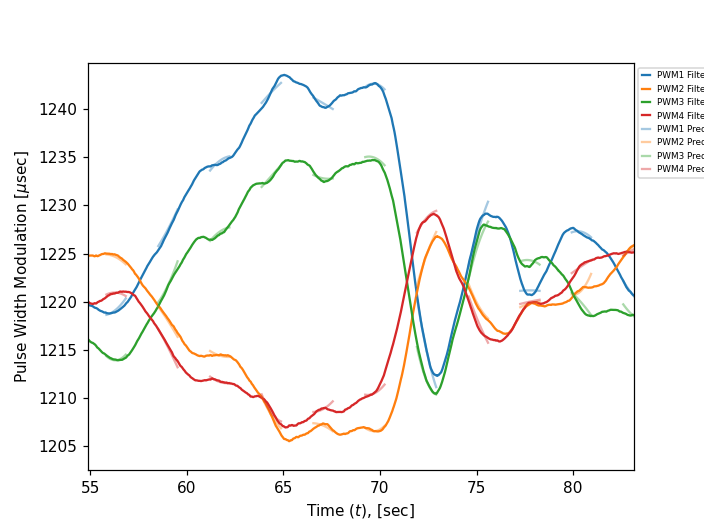

In [82]:
import scipy

# Plotting the control outputs
fig, ax = plt.subplots(1, 1)

# Targets
ax.plot(tvec, pwms[:,0], label='PWM1 Filtered', color='C0')
ax.plot(tvec, pwms[:,1], label='PWM2 Filtered', color='C1')
ax.plot(tvec, pwms[:,2], label='PWM3 Filtered', color='C2')
ax.plot(tvec, pwms[:,3], label='PWM4 Filtered', color='C3')

# Trained outputs
n = 500 # 1000
t_span = 1.  # 1 second future window
t_b_plot = np.linspace(0., 1., 101)  # vector for plotting continuous function

b_weights = np.zeros((n_b_points,)+t_b_plot.shape)  # memory allocation
for i in range(n_b_points):
    b_weights[i,:] = scipy.special.comb(n_b_points - 1, i)*((1. - t_b_plot)**(n_b_points - 1 - i))*(t_b_plot**i)
    
ypred_b_plotting = np.einsum('ijk,jl->ikl', ypred_b, b_weights)

for i in range(int(ypred.shape[0]/n)):
    for j in range(4):
        ax.plot(
            tvec_y[n*i,0] + t_span*t_b_plot,
            ypred_b_plotting[n*i, j, :],
            color=('C%i' % j),
            alpha=0.4,
            label=(('' if i == 0  else '_') + ('PWM%i' % (j+1)) + ' Predicted')
        )

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='xx-small', handlelength=1)

ax.set_xlabel('Time ($t$), [sec]')
ax.set_ylabel('Pulse Width Modulation [$\mu$sec]')
plt.show()

<IPython.core.display.Javascript object>


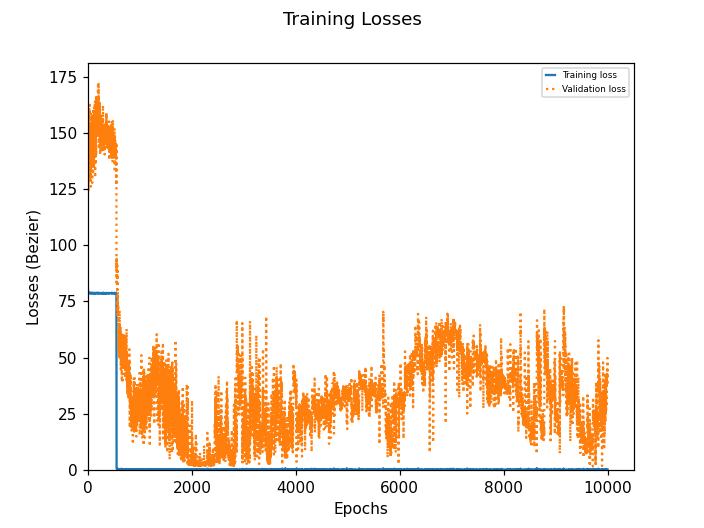

In [83]:
fig, ax_t = plt.subplots(1, 1)

lvec = np.array(hist.history['loss'])
vlvec = np.array(hist.history['val_loss'])
epoch_vec = np.array(list(range(lvec.shape[0])))
    
ax_t.plot(epoch_vec, lvec, label='Training loss')
ax_t.plot(epoch_vec, vlvec, linestyle=':', label='Validation loss')

ax_t.set_xlim(left=0)
ax_t.set_ylim(bottom=0)

fig.suptitle('Training Losses')
ax_t.legend(fontsize='xx-small', handlelength=1)
ax_t.set_xlabel('Epochs')
ax_t.set_ylabel('Losses (Bezier)')
plt.show()